# TODO
1. ~~Make list~~
2. ~~[Get GPU working?](https://pytorch.org/docs/stable/notes/faq.html)~~
3. ~~Change model for generator Transposed convolution~~
4. Compress using discriminator
5. Debug training to find where memory goes WHOOOOOP


4. Fix Checkerboard Pattern
5. Train on single Genre
6. Upgrade our Discriminator (More CNN)
7. "Tunning" 

    a. Stride

    b. ~~CNN Nonsense~~
8. Run that shit all day
9. Train to generate specific Genere
10. Increase image resolution 

In [1]:
import fastbook
from fastbook import *
#import torch
#print(torch.cuda.is_available())
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc
from PIL import Image
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf


In [2]:
path = Path.BASE_PATH = r".\all"

music = DataBlock(blocks = (ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items= get_image_files,
        splitter = RandomSplitter(seed=23),
        get_y = using_attr(RegexLabeller(r'^([^.]+)'), 'name'))
dls = music.dataloaders(path, bs=4)
dls

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [3]:
music.summary(path)

Setting-up type transforms pipelines
Found 100 items
2 datasets of sizes 80,20
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      all\country.00031.png
    applying PILBase.create gives
      PILImageBW mode=L size=1024x128
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      all\country.00031.png
    applying partial gives
      country
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImageBW mode=L size=1024x128, TensorCategory(0))


Found 100 items
2 datasets of sizes 80,20
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is chan

In [ ]:

#torch.cuda.empty_cache()
#dls.show_batch(nrows=2, ncols=2)
#dls.show_batch(max_n=9, figsize=(8,6))


#def clear_memory():
#    gc.collect()
#    torch.cuda.empty_cache()

# Discriminator

In [4]:
#torch.cuda.empty_cache()
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(515088, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, image):
        return self.discriminator(image)

#discriminator = Discriminator().cuda()
#batch_x,y = dls.valid.one_batch()
#x, y = batch_x.cuda(), y.cuda()
#out = discriminator(batch_x)
#out

In [ ]:
#clear_memory()

# Generator

In [ ]:
#854x63 53802
#class Generator(nn.Module):
#    def __init__(self, z_dim=10):
#        super(Generator, self).__init__()
#        self.generator = nn.Sequential(
#            nn.Linear(10,100),
#            nn.Linear(100,53802),
#            nn.Sigmoid()
#        )
#    def forward(self, x):
#        return self.generator(x)


#x = torch.rand(4, 10).cuda()
#gen = Generator().cuda()
#y = gen(x)
#del y
#clear_memory()

In [5]:
class Reshape(nn.Module):
    """
    Class for performing a reshape as a layer in a sequential model.
    """
    def __init__(self, shape=[]):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)
    
    def extra_repr(self):
            # (Optional)Set the extra information about this module. You can test
            # it by printing an object of this class.
            return 'shape={}'.format(
                self.shape
            )

In [8]:
class AreTwoGenTwo(nn.Module):
    #def __init__(self, z_dim=10, img_size=(64,16,213)):
    def __init__(self, z_dim=10, img_size=(64,31,255)):
        super(AreTwoGenTwo, self).__init__()
        self.flat_img = int(np.prod(img_size))
        self.generator = nn.Sequential(
            # Fully connected layers
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            #nn.ReLu(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, self.flat_img),
            #nn.ReLu(True),
            nn.LeakyReLU(0.2, inplace=True),
            Reshape(img_size),

            nn.ConvTranspose2d(64,32, 5, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32,1,4, stride=2, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.generator(x)

#x = torch.rand(4, 10).cuda()
#gen = AreTwoGenTwo().cuda()
#y = gen(x)

#y.shape

In [ ]:
#image = y[0,0].detach().to("cpu").numpy() 

#plt.figure(figsize=(40,10))
#plt.imshow(image)

In [ ]:
#im = Image.fromarray(image).convert('RGB')
#im.save("Generated.jpeg")

## Discriminator Loss

In [9]:
def get_noise(num_images, z_dim, device="cuda"):
    noise = None
    if device == "cuda":
        noise = torch.rand(num_images,z_dim , device=device).cuda()
    else:
        noise = torch.rand(num_images, z_dim)
    return noise


In [10]:
def get_disc_loss(gen, disc, criterion, real_input, num_images, z_dim, device="cuda"):
    '''
    Return Loss of discriminator 
    Params: 
    Gen: Geneartor model
    Disc: Discrimiator Model
    criterion: Loss function
    Real Input: Our data set images
    Num_images: Len(real input)
    z_dim: Dimention of our noise vector
    Return a loss value for 1 batch
    '''
    
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    fake_images = torch.reshape(fake_images, (4, 1, 128, 1024))
    fake_images.detach()
    fake_loss = criterion(disc(fake_images), torch.zeros((num_images,1),device=device))
    real_loss = criterion(disc(real_input), torch.ones((num_images,1),device=device))
    disc_loss = (fake_loss + real_loss)/2
    return disc_loss

def test_disc():
    gen = AreTwoGenTwo().cuda()
    disc = Discriminator().cuda()
    criterion = nn.BCEWithLogitsLoss()
    x,y = dls.valid.one_batch()
    num_images = len(x)
    z_dim = 10
    loss = get_disc_loss(gen, disc, criterion, x, num_images, z_dim)
    return loss
    
#loss = test_disc()
#print(loss)


# Both Loss

In [11]:
def get_loss(gen, disc, criterion, real_input, num_images, z_dim, device="cuda"):
    #Make Fake Images
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    fake_images = torch.reshape(fake_images, (4, 1, 128, 1024))
    fake_images.detach()
    #Get discriminators predictions
    prediction = disc(fake_images)
    #Calculate Losses
    #Gen Loss
    gen_loss = criterion(prediction, torch.ones(num_images,1, device=device))
    #Disc Loss
    fake_loss = criterion(prediction, torch.zeros((num_images,1),device=device))
    real_loss = criterion(disc(real_input), torch.ones((num_images,1),device=device))
    disc_loss = (fake_loss + real_loss)/2
    return disc_loss, gen_loss

# Generator Loss

In [12]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device="cuda"):
    '''
    Returns the loss of the generator
    Params: 
    Gen: Generator Model
    Disc: Discrimiator Model
    Criterion: Loss Function
    num_images: The number of images the generator should produce
    z_dim: The dim of the noise vector
    Device: What device we run it on
    '''
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    fake_images = torch.reshape(fake_images, (4, 1, 128, 1024))
    fake_images.detach()
    prediction = disc(fake_images)
    gen_loss = criterion(prediction, torch.ones(num_images,1, device=device))
    return gen_loss

def test_gen_loss():
    gen = Generator().cuda()
    disc = Discriminator().cuda()
    criterion = nn.BCEWithLogitsLoss()
    num_images = 4 
    z_dim = 10
    loss = get_gen_loss(gen, disc, criterion, num_images, z_dim)
    return loss

#loss = test_gen_loss()
#print(loss)
#loss = None

# Training

In [ ]:
#clear_memory()

In [14]:
criterion = nn.BCELoss()
n_epochs = 200
z_dim = 10
#batch_size = 4

device = "cuda"
#device = "cpu"
gen = AreTwoGenTwo().to(device)
gen_opt = torch.optim.Adam(gen.parameters())
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters())

cur_step = 0 
disc_loss_hist = [] 
gen_loss_hist = []

for epoch in range(n_epochs):
    disc_loss_batch = 0.0
    gen_loss_batch = 0.0
    batch_size = len(dls.train)
    for batch in dls.train:
        real_images, *_ = batch
        real_images = real_images.to(device)
        num_images = len(real_images)
        #Train discriminator
        disc_opt.zero_grad()
        disc_loss, gen_loss = get_loss(gen, disc, criterion, real_images, num_images, z_dim, device)
        disc_loss_batch+=disc_loss.item()
        #BREAKS
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        #Train Generator
        gen_opt.zero_grad()
        gen_loss_batch+=gen_loss.item()
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        #print("Batch")
    print("Epoch: " + str(epoch))
    print(disc_loss_batch/batch_size)
    print(gen_loss_batch/batch_size)
    disc_loss_hist.append(disc_loss_batch/batch_size)
    gen_loss_hist.append(gen_loss_batch/batch_size)
    

        
        

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [64, 1]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [12]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    7189 MB |    8713 MB |   11374 MB |    4184 MB |\n|       from large pool |    7187 MB |    8711 MB |   11366 MB |    4179 MB |\n|       from small pool |       1 MB |       3 MB |       7 MB |       5 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    7189 MB |    8713 MB |   11374 MB |    4184 MB |\n|       from large pool |    7187 MB |    8711 MB |

C:\Users\ldscho\AppData\Local\Temp/ipykernel_14148/1812301451.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


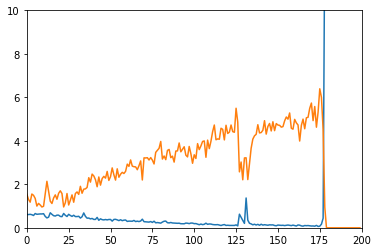

In [ ]:
fig,ax = plt.subplots()
ax.plot(disc_loss_hist)
ax.set_xlim(0,200)
ax.set_ylim(0, 10)
ax.plot(gen_loss_hist)
fig.show()

In [ ]:
def make_image(gen):
    x = torch.rand(4, 10).to("cuda")
    y = gen(x)
    return y
y = make_image(gen)
image = torch.reshape(y, (4, 1, 66, 854))


In [ ]:
y = y.detach().to("cpu").numpy()
y.ndim
image = image[0,0].detach().to("cpu").numpy() 


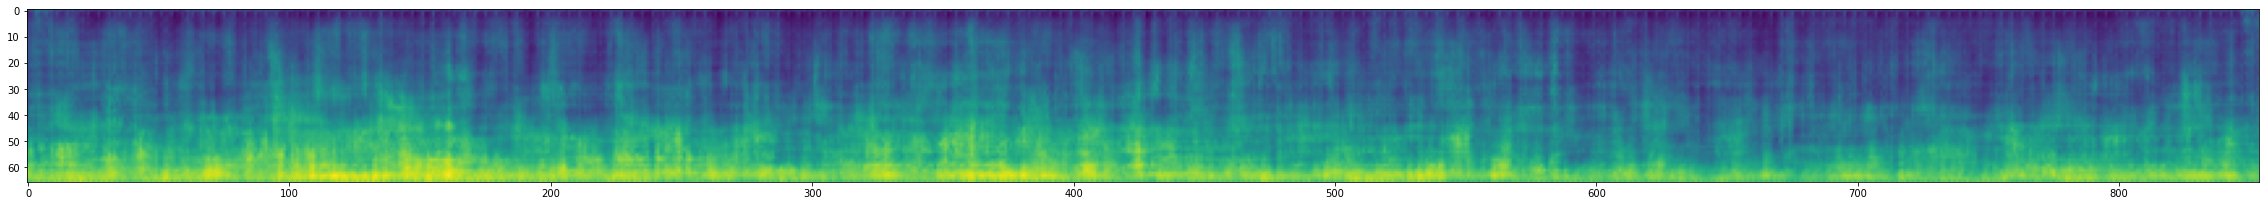

In [ ]:

plt.figure(figsize=(40,10))
plt.imshow(image)

In [ ]:
im = Image.fromarray(image).convert('RGB')
im.save("Generated.jpeg")

### old 

In [ ]:
def generate_spectrogram(x, sr, save_name):
    #Creates the spectro gram
    spectro = librosa.sft(x)
    #Convert to decible 
    #Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(66,854))
    ax = fig.add_axes([0,0,1,1], frameon=False)
    ax.axis("off")
    librosa.display.specshow(spectro, sr=sr, cmap='grey', x_axis='time', y_axis ="hz")
    plt.savefig(save_name, quality=100, bbox_inches=0, pad_inches=0)
    librosa.cache.clear()
    return spectro

In [ ]:
write("example2.wav", samplerate, lInverse.astype(np.int16))

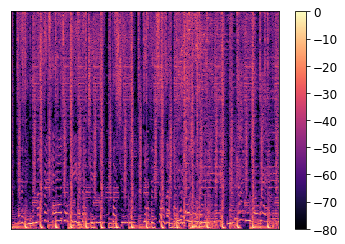

In [ ]:
y, sr = librosa.load(r"C:\Users\ldscho\Downloads\pop.00001.wav", duration=10)
S = np.abs(librosa.stft(y))

S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

y_inv = librosa.griffinlim(S)
sf.write('pop.wav', y_inv, sr)

In [45]:
y, sr = librosa.load(r"C:\Users\ldscho\Downloads\pop.00001.wav")
M = librosa.feature.melspectrogram(y=y, sr=sr)

lM = M.astype(np.uint8)

im = Image.fromarray(lM)
im.save("lM.png")

#image = Image.open(r"C:\Users\ldscho\spectro\ml_expore\lM.png")
#data = np.asarray(image)

S = librosa.feature.inverse.mel_to_stft(data.astype(np.float64))
y = librosa.griffinlim(S)

sf.write("lM.wav", y, sr)

NameError: name 'lM' is not defined

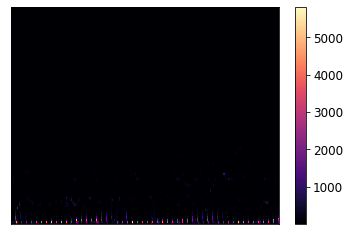

In [ ]:
plt.figure()
librosa.display.specshow(M)
plt.colorbar()

In [ ]:
M.shape

(128, 1293)

In [ ]:
def audio_to_spectrogram_and_back():
    x, sr = librosa.load(r"C:\Users\ldscho\Downloads\blues.00007.wav", duration=10)
    S = np.abs(librosa.stft(x))
    x_inv = librosa.griffinlim(S)
    sf.write("examplefinal.wav", x_inv, sr)
    return x_inv, S

In [ ]:
a, b = audio_to_spectrogram_and_back()

### new

In [61]:
def mel_generate(path):
    #[^\]*(?=[.][a-zA-Z]+$)
    pattern = re.compile(r'(.+)(\\)(?P<name>.+)(.wav)')
    for music_name in os.listdir(path):
        file_name = os.path.join(path, music_name)
        if os.path.isfile(file_name):
            match = list((re.finditer(pattern, file_name)))
            name = match[0].groupdict()['name']
            print(file_name)

            y, sr = librosa.load(file_name, duration=23.77)
            M = librosa.feature.melspectrogram(y=y, sr=sr)

            lM = M.astype(np.uint8)

            im = Image.fromarray(lM)
            im.save(name + ".png")

#mel_generate(r"C:\Users\ldscho\spectro\ml_expore\genres_original\country")

C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00000.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00001.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00002.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00003.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00004.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00005.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00006.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00007.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00008.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00009.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00010.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00011.wav
C:\Users\ldscho\spectro\ml_expore\genres_original\country\country.00012.wav
C:\Users\lds